In [1]:
# imports
import string
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

import sys
sys.path.append("..")
import utils

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [2]:
# stolen from notebook9
filename = "glove.6B.50d.txt"

embeddings = {}
with open(filename,'r', encoding='utf-8') as file:
    for line in file:
        elements = line.split();
        word = elements[0];
        vector = np.asarray(elements[1:],"float32")
        embeddings[word] = vector

In [3]:
# functions
def preprocess(text, punctuation=False):
    """
    Parameters:
    text (string): raw text from data

    Returns:
    string: string with no punctuation and
            only contains words in embeddings
    """
    if punctuation:
        text_ = ""
        for char in text:
            if char not in string.punctuation:
                text_ += char
        text = text_
    
    text_ = ""
    for word in text.split():
        if word in embeddings:
             text_ += word.lower() + " "
    return text_

def mean_emb(text):
    """
    Parameters:
    text (string): raw text from data
    
    Returns:
    numpy.ndarray(50,): mean embedding of text
    """
    pre = preprocess(text).split()
    sum_emb = np.zeros(50,)
    for word in pre:
        sum_emb += embeddings[word]
    mean_emb = sum_emb/50
    
    return mean_emb

def glove_accuracy(X_train, X_test, y_train, y_test):
    train_embeddings = np.array([mean_emb(text) for text in X_train])
    test_embeddings = np.array([mean_emb(text) for text in X_test])

    clf = GaussianNB().fit(train_embeddings, y_train)

    predictions = clf.predict(test_embeddings)
    accuracy = accuracy_score(y_test, predictions)

    return accuracy

In [4]:
## Spam data

In [5]:
spam_train, spam_test = utils.load_data('spam')
glove_accuracy(spam_train['texts'], spam_test['texts'], spam_train['labels'], spam_test['labels'])

0.9336322869955157

In [6]:
news_train, news_test = utils.load_data('news')
glove_accuracy(news_train['texts'], news_test['texts'], news_train['labels'], news_test['labels'])

0.84

## PCA

## sms

In [277]:
# week9 NB
def plot_pca(X_train, y_train, PC_range, num_texts):
    """
    xtrain = texts to be plotted
    ytrain = labels of the texts
    PC_range = list with start stop eigenvalues for projection
    num_texts = if you dont want all the texts to be plotted (it can be crowded),
    None for all texts
    """
    vectors = np.zeros((50,len(X_train)))
    for i in range(len(X_train)):
        doc = X_train[i]
        vectors[:,i] = mean_emb(doc)
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    #compute the covariance matrix
    S = np.cov(data)
    #obtain eigenvectors and eigenvalues
    eigenValues, eigenVectors = eigh(S)
    #sort according to size of eigenvalues
    sort_idx = np.argsort(eigenValues)[::-1]
    eigenValues = eigenValues[sort_idx]
    eigenVectors = eigenVectors[:, sort_idx]
    X_proj = eigenVectors[:,PC_range[0]:PC_range[1]].T@data    
    #plot for the selected two principal components
    for label, x, y in zip(y_train, X_proj[0,:num_texts], X_proj[1,:num_texts]):
        if label == 0:
            color = "blue"
        elif label == 1:
            color = 'red'
        elif label == 2:
            color = 'green'
        elif label == 3:
            color = 'cyan'
        
        plt.plot(x,y,"*",color=color)
    plt.show()

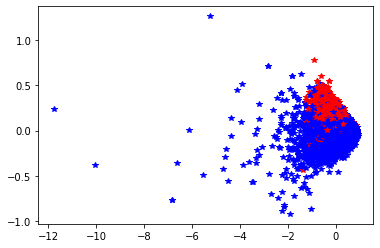

In [275]:
# show the PCA based on the 2 most important directions
# not spam as blue
plot_pca(spam_train['texts'], spam_train['labels'], [0,2], None)

In [279]:
def pca(X_train):
    """
    xtrain = texts to be plotted
    ytrain = labels of the texts
    PC_range = list with start stop eigenvalues for projection
    num_texts = if you dont want all the texts to be plotted (it can be crowded)
    """
    vectors = np.zeros((50, len(X_train)))
    for i in range(len(X_train)):
        doc = X_train[i]
        vectors[:,i] = mean_emb(doc)
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    #compute the covariance matrix
    S = np.cov(data)
    #obtain eigenvectors and eigenvalues
    eigenValues, eigenVectors = eigh(S)
    #sort according to size of eigenvalues
    sort_idx = np.argsort(eigenValues)[::-1]
    eigenValues = eigenValues[sort_idx]
    eigenVectors = eigenVectors[:, sort_idx]
    return eigenValues, eigenVectors

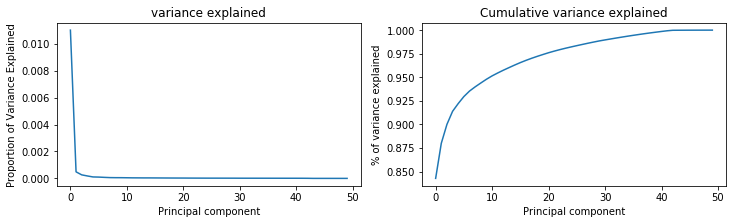

In [280]:
# explained variance
# week5 NB
eigenValues, eigenVectors = pca(spam_train['texts'])

summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(50)
relative_var = np.zeros(50)
for i in range(50):    
    relative_var[i] = eigenValues[i]/np.size(eigenValues)
    cumsum += eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
# this might not be calculated correctly (line 10)
plt.plot(relative_var)
plt.xlabel("Principal component")
plt.ylabel("Proportion of Variance Explained")
plt.title('variance explained');
plt.subplot(122) 
plt.plot(total_var_explained)
plt.xlabel("Principal component")
plt.ylabel("% of variance explained")
plt.title('Cumulative variance explained');

Maybe add a vertical line at x=2

In [248]:
total_var_explained[0:2]

array([0.84271529, 0.87993501])

### News

Currently it just shows the first 5000 articles, we could maybe change it to be 5000 random. np.random.choice()

Or we could just say that the first 5k are representative of the population

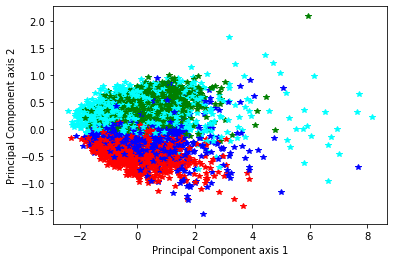

In [281]:
plt.xlabel('Principal Component axis 1');
plt.ylabel('Principal Component axis 2');
# World = "blue", 'sports' = 'red', 'Business'= 'green', 'Sci/Tec'='cyan'
plot_pca(news_train['texts'], news_train['labels'], [0,2], 5000)

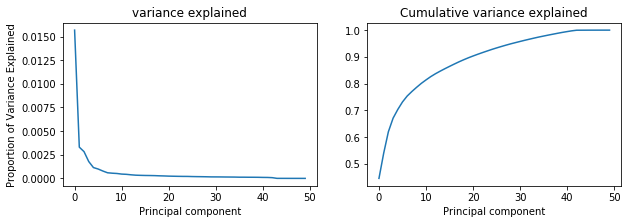

In [282]:
# explained variance
eigenValues, eigenVectors = pca(news_train['texts'])

summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(50)
relative_var = np.zeros(50)
for i in range(50):    
    relative_var[i] = eigenValues[i]/np.size(eigenValues)
    cumsum += eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig = plt.figure(figsize=(10,3))
plt.subplot(121)    
plt.plot(relative_var)
plt.xlabel("Principal component")
plt.ylabel("Proportion of Variance Explained")
plt.title('variance explained');
plt.subplot(122) 
plt.plot(total_var_explained)
plt.xlabel("Principal component")
plt.title('Cumulative variance explained');